In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import torch
import torch.nn as nn

from IPython import display

One of the downsides of the basic image processing strategy is that is requires that you hand designed rules for detection, which limits you to relatively simple choices and will reduce performance. A machine learning approach is to learn these filters (or rules) from example training data. We'll briefly introduce a deep learning strategy to do this here. We'll use [pytorch](https://pytorch.org/tutorials/beginner/basics/intro.html), a deep learning software library to train a simple neural network that can predict a target object location.

## Generate some training/ test data

In practice, the hardest part of supervised machine learning is dataset collection and cleaning. If you use this strategy in your project, you will need to label many images with target object positions. Our toy datatset will consist of randomly placed red squares on a noisy background. 

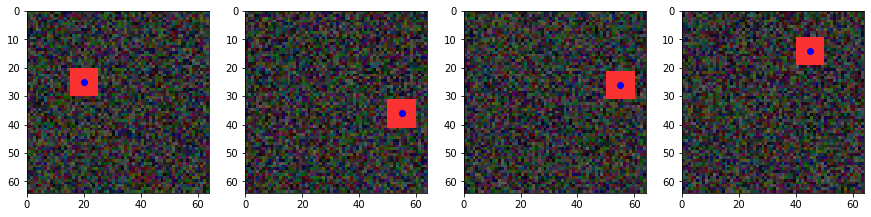

In [6]:
## Generate some data

N = 1000
X = (100*np.random.rand(N,64,64,3)).astype(int) # block images

Y = np.random.randint(5,59,size=(N,2)) # block positions

for j in range(N):
    X[j,Y[j,1]-5:Y[j,1]+5,Y[j,0]-5:Y[j,0]+5,0] = 250
    X[j,Y[j,1]-5:Y[j,1]+5,Y[j,0]-5:Y[j,0]+5,1] = 50
    X[j,Y[j,1]-5:Y[j,1]+5,Y[j,0]-5:Y[j,0]+5,2] = 50
    
plt.figure(figsize=(15,5))
for j in range(4):
    plt.subplot(1,4,j+1)
    plt.imshow(X[j,:,:,:],extent=[0,64,64,0])
    plt.plot(Y[j,0],Y[j,1],'bo')
plt.show()

Our dataset consists of images, stored in the variable X, and corresponding 2D object positions, stored in the variable Y. We'll split our data into two, one set for training, and keep another set aside for testing.

In [7]:
Xtrain = X[0:500,:,:,:]
Ytrain = Y[0:500,:]

Xtest = X[500:,:,:,:]
Ytest = Y[500:,:]

### Defining a simple CNN using PyTorch

We'll now build a very basic convolutional neural network for regression. Our network will consist of 3 convolution layers (filters with learnable parameters) and 2 fully connected layers. We'll use relu activations to introduce non-linearities into the network, and use a final tanh activation to make sure our network predicts values between -1 and 1. We'll also scale our training data to follow this constraint too.

NB: This is a basic model for demonstration purposes - it should work on very simple datasets, and might work on the type of images you'll get in the arena, but there are much better models out there. Check out [YOLO](https://pjreddie.com/darknet/yolo/) and think about looking into fine tuning a pre-trained model.



In [8]:
# Define a simple CNN
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

# The Detector class will be our detection model
class Detector(nn.Module):

    def __init__(self,output_dim,image_channels):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 3, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(3, 3, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(3, 3, 3, stride=2, padding=1),
            nn.ReLU(),
            Flatten(),
            nn.Linear(192,128),
            nn.ReLU(),
            nn.Linear(128,output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        
        positions = self.encoder(x)
        
        return positions

In [9]:
# Now we'll declare our network
network = Detector(output_dim=2,image_channels=3)

### Training our model

Ok, so we've defined our network, now we will pass our training data through this network in manageable batches, compute the prediction error, and adjust the network parameters to reduce this error. We'll use the Adam optimizer to do this, and repeat a number of times.

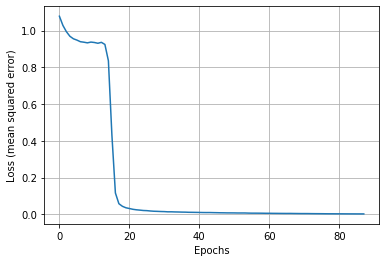

In [ ]:
Nepochs = 100
Nbatch = 8

optimizer = torch.optim.Adam(network.parameters(),lr=1e-4)

losses = []
for j in range(Nepochs):
    
    # Shuffle our training data after each epoch
    idxs = np.arange(Xtrain.shape[0])
    np.random.shuffle(idxs)
    
    Xtrain = Xtrain[idxs,:,:,:]
    Ytrain = Ytrain[idxs,:]
    
    # Loop over training data in batches of images
    batch_losses = []
    for k in range(int(Xtrain.shape[0]/Nbatch)):
        
        # Scale images and positions to be between 0 and 1 and convert to tensors for pytorch
        Xbatch = torch.from_numpy(Xtrain[Nbatch*k:Nbatch*(k+1),:,:,:]).float().transpose(1,3)/255
        Ybatch = torch.from_numpy(Ytrain[Nbatch*k:Nbatch*(k+1),:]).float()/64-0.5
        
        # Predict positions using neural network
        Ypred = network(Xbatch)
        
        # Calulate the loss (error between predictions and true values)
        loss = torch.sum((Ypred-Ybatch)**2)
        
        # Zero existing gradients
        optimizer.zero_grad()
        
        # Adjust neural network weights and biases by taken a step in a direction that reduces the loss
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())
        
    losses.append(np.mean(batch_losses))
    
    
    plt.clf()
    plt.plot(losses)
    plt.ylabel('Loss (mean squared error)')
    plt.xlabel('Epochs')
    plt.grid()

    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
        
    

### Testing our model

Ok, so our average error is pretty low, lets test on sample random images from our test set. We'll just do this as a sanity check, if you want to be sure, it's a good idea to test on the whole test set and compute some error metrics.

In [ ]:
k = np.random.randint(Xtest.shape[0]/Nbatch)
test_ims = torch.from_numpy(Xtest[Nbatch*k:Nbatch*(k+1),:,:,:]).float().transpose(1,3)/255
Ypred = network(test_ims).detach().numpy()

plt.figure(figsize=(15,5))
for j in range(Nbatch):
    plt.subplot(1,Nbatch,j+1)
    plt.imshow(Xtest[Nbatch*k+j,:,:,:].squeeze(),extent=[0,64,64,0])
    
    pos_pred = (Ypred+0.5)*64 # Scale predictions to pixel coordinates
    
    # Show predicted marker positions in image
    plt.plot([pos_pred[j,0]],[pos_pred[j,1]],'bo',markersize=5)
plt.show()

Once trained, you can save a model and then load this to re-use in another program. See [this link](https://pytorch.org/tutorials/beginner/saving_loading_models.html) for details. In typical use, you'll pass each image through this network as they are received, as shown below.

In [ ]:
im = Xtest[100,:,:,:].reshape(1,64,64,3)
torch_im = torch.from_numpy(im).transpose(1,3)/255.0 # Convert to torch tensor, reshape and normalise
torch_pos = network(torch_im) # Feed through network

pos = (torch_pos.detach().numpy()+0.5)*64 #Convert back to numpy

print('Detected position: ',pos)

Cool, we have a simple object recognition strategy. You may find that lighting and motion blur makes this ineffective through, and you need a lot of data to make this work. You'll also find that your robot moves in a 3D world, but this is a 2D detection in image space. Mapping between these spaces can be difficult. If you know the geometry of the object and properties of your camera, it is possible to infer the 3D location of the object. (See https://docs.opencv.org/master/d9/d0c/group__calib3d.html)

But if you don't know this, the best option might be to do visual servoing - rotating the robot so that the target object moves to a desired position in the image. You could try to adopt a proportional control approach, like the one we used previously, but acting on the image error.